In [194]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from iminuit import Minuit

In [271]:
Ax_mean, Ax_width = 17., 3.
Ay_mean, Ay_width = 118., 4.

Bx_mean, Bx_width = 8., 15.
By_mean, By_width = 150., 42.

def prob_gauss (x, y, x_mean, x_width, y_mean, y_width) :
    return stats.norm.pdf(x, x_mean, x_width) * stats.norm.pdf(y, y_mean, y_width)

def sample_gauss (N_points, x_mean, x_width, y_mean, y_width) :
    x = np.random.normal(x_mean, x_width, N_points)
    y = np.random.normal(y_mean, y_width, N_points)
    return np.array([x, y]).transpose()

def prob_A (x, y) :
    return prob_gauss (x, y, Ax_mean, Ax_width, Ay_mean, Ay_width)

def sample_A (N_points) :
    return sample_gauss (N_points, Ax_mean, Ax_width, Ay_mean, Ay_width)

def prob_B (x, y) :
    return prob_gauss (x, y, Bx_mean, Bx_width, By_mean, By_width)

def sample_B (x, y) :
    return sample_gauss (N_points, Bx_mean, Bx_width, By_mean, By_width)


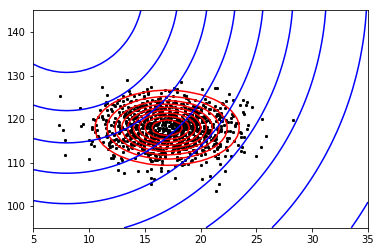

In [272]:
n_samples = 1000

X, Y = np.linspace(5, 35, 51), np.linspace(95, 145, 51)
X_grid, Y_grid = np.meshgrid(X, Y)
Z_grid_A, Z_grid_B = np.zeros(shape=X_grid.shape), np.zeros(shape=X_grid.shape)
for i, x in enumerate(X) :
    for j, y in enumerate(Y) :
        Z_grid_A [i, j] = prob_A(X_grid [i, j], Y_grid [i, j])
        Z_grid_B [i, j] = prob_B(X_grid [i, j], Y_grid [i, j])

Z_max_A = prob_A(Ax_mean, Ay_mean)
Z_max_B = prob_B(Bx_mean, By_mean)

datapoints = sample_A(n_samples)

plt.contour(X_grid, Y_grid, Z_grid_A, levels=np.linspace(0.1, 0.9, 9)*Z_max_A, colors="red")
plt.contour(X_grid, Y_grid, Z_grid_B, levels=np.linspace(0.1, 0.9, 9)*Z_max_B, colors="blue")
plt.scatter(datapoints[:,0], datapoints[:,1], marker='x', s=5, color="black")
plt.show()

In [273]:
frac_A = 0.1
frac_B = 1. - frac_A

def prob_A_plus_B (x, y) :
    return frac_A*prob_A(x, y) + frac_B*prob_B(x, y)

def sampled_probs (x_min, x_max, y_min, y_max) :
    num_pass_A      = 0
    mean_prob_ratio = 0.
    for d in datapoints :
        x, y  = d[0], d[1]
        if x < x_min : continue
        if x > x_max : continue
        if y < y_min : continue
        if y > y_max : continue
        num_pass_A      = num_pass_A + 1
        mean_prob_ratio = mean_prob_ratio + (prob_B(x, y) / prob_A(x, y))
    mean_prob_ratio = mean_prob_ratio / len(datapoints)
    pA = num_pass_A / len(datapoints)
    pB = mean_prob_ratio
    return pA, pB

def actual_probs (x_min, x_max, y_min, y_max) :
    pA = stats.norm.cdf(x_max, Ax_mean, Ax_width) - stats.norm.cdf(x_min, Ax_mean, Ax_width)
    pA = pA * (stats.norm.cdf(y_max, Ay_mean, Ay_width) - stats.norm.cdf(y_min, Ay_mean, Ay_width))
    pB = stats.norm.cdf(x_max, Bx_mean, Bx_width) - stats.norm.cdf(x_min, Bx_mean, Bx_width)
    pB = pB * (stats.norm.cdf(y_max, By_mean, By_width) - stats.norm.cdf(y_min, By_mean, By_width))
    return pA, pB
    

In [274]:
actual_probs(15, 20, 110, 130)

(0.574660852642572, 0.01589916240148539)

In [275]:
sampled_probs(15, 20, 110, 130)

(0.555, 0.013845906703939091)

In [298]:
def actual_significance (x_min, x_max, y_min, y_max) :
    pA, pB = actual_probs (x_min, x_max, y_min, y_max)
    return pA / np.sqrt(frac_A*pA + frac_B*pB)

In [301]:
print("Running fit")
fit_func = lambda x : -1. * actual_significance(x[0], x[1], x[2], x[3])
m = Minuit.from_array_func(fit_func,
                            [15, 18, 115, 120],
                            error=[5, 5, 5, 5],
                            errordef=1.)
m.migrad()
print(m.get_param_states())
print(m.get_fmin())

Running fit
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |    11     |    10     |            |            |         |         |       |
| 1 | x1   |    24     |    13     |            |            |         |         |       |
| 2 | x2   |    109    |    16     |            |            |         |         |       |
| 3 | x3   |    126    |    14     |            |            |         |         |       |
------------------------------------------------------------------------------------------
------------------------------------------------------------------
| FCN = -2.661                  |      Ncalls=79 (79 total)      |
| EDM = 5.13E-05 (Goal: 1E-05)  |            up = 1.0            |
-----------------------------------------------------------

In [293]:

def significance_with_error (x_min, x_max, y_min, y_max, samples) :
    if x_min > x_max : return x_min - x_max, 100.
    if y_min > y_max : return y_min - y_max, 100.
    num_pass_A  = 0
    sumw, sumw2 = 0., 0.
    for d in samples :
        x, y  = d[0], d[1]
        if x < x_min : continue
        if x > x_max : continue
        if y < y_min : continue
        if y > y_max : continue
        num_pass_A      = num_pass_A + 1
        weight = (prob_A_plus_B(x, y) / prob_A(x, y))
        sumw  = sumw  + weight
        sumw2 = sumw2 + weight * weight
    mean_prob_ratio     = sumw / len(samples)
    mean_prob_ratio_err = np.sqrt(sumw2) / len(samples)
    pA = num_pass_A / len(samples)
    sig = pA / np.sqrt(mean_prob_ratio)
    sig_err =  0.5 * sig * mean_prob_ratio_err / mean_prob_ratio
    if mean_prob_ratio == 0 :
        sig, sig_err = 0., 0.
    return sig, sig_err

In [303]:
for i in range(10) :
    samples = sample_A(n_samples)
    x_min, x_max, y_min, y_max = np.min(samples[:,0]), np.max(samples[:,0]), np.min(samples[:,1]), np.max(samples[:,1])
    def fit_func (x) :
        sig, sig_err =  significance_with_error(x[0], x[1], x[2],  x[3], samples)
        #print(x[0], x[1], x[2],  x[3], sig, sig_err, sig/sig_err)
        frac_sig_err = sig / sig_err if sig_err > 0 else 0
        prior_sig = np.exp(frac_sig_err-5) / (1+np.exp(frac_sig_err-5))
        #prior_x0 = stats.norm.pdf(x[0], 15, 30)
        #prior_x1 = stats.norm.pdf(x[1], 15, 30)
        #prior_x2 = stats.norm.pdf(x[2], 115, 50)
        #prior_x3 = stats.norm.pdf(x[3], 115, 50)
        return -1. * sig # * prior_sig # * prior_x0 * prior_x1 * prior_x2 * prior_x3
    print("Running fit")
    m = Minuit.from_array_func(fit_func,
                               [15, 18, 115, 120],
                               error=[5, 5, 5, 5],
                               errordef=1.,
                               limit=[(x_min, x_max), (x_min, x_max), (y_min, y_max), (y_min, y_max)])
    m.migrad()
    print(m.get_param_states())
    print(m.get_fmin())

Running fit
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |    27     |     0     |            |            | 4.74994 | 27.2066 |       |
| 1 | x1   |     5     |     0     |            |            | 4.74994 | 27.2066 |       |
| 2 | x2   |    127    |     0     |            |            | 103.088 | 129.949 |       |
| 3 | x3   |    110    |     0     |            |            | 103.088 | 129.949 |       |
------------------------------------------------------------------------------------------
------------------------------------------------------------------
| FCN = -22.46                  |     Ncalls=195 (195 total)     |
| EDM = 5.17E-07 (Goal: 1E-05)  |            up = 1.0            |
-----------------------------------------------------------

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |     8     |    17     |            |            | 5.89639 | 26.0393 |       |
| 1 | x1   |    24     |    11     |            |            | 5.89639 | 26.0393 |       |
| 2 | x2   |   113.0   |    1.0    |            |            | 102.487 | 130.751 |       |
| 3 | x3   |   126.0   |    2.0    |            |            | 102.487 | 130.751 |       |
------------------------------------------------------------------------------------------
------------------------------------------------------------------
| FCN = -2.555                  |     Ncalls=378 (389 total)     |
| EDM = 0.00352 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  V

In [227]:
print(m.get_param_states())

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   11.4    |    2.0    |            |            |         |         |       |
| 1 | x1   |   23.8    |    2.0    |            |            |         |         |       |
| 2 | x2   |   110.5   |    2.0    |            |            |         |         |       |
| 3 | x3   |   124.8   |    1.9    |            |            |         |         |       |
------------------------------------------------------------------------------------------


In [220]:
print(m.get_param_states())

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |     7     |     3     |            |            |         |         |       |
| 1 | x1   |   24.7    |    2.8    |            |            |         |         |       |
| 2 | x2   |    101    |     6     |            |            |         |         |       |
| 3 | x3   |   124.1   |    1.2    |            |            |         |         |       |
------------------------------------------------------------------------------------------
